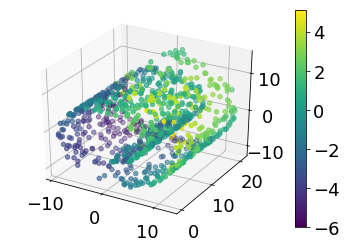

1/300 ... likelihood: -5617.682035062459
2/300 ... likelihood: -5399.261989692244
3/300 ... likelihood: -5272.575104999883
4/300 ... likelihood: -5192.865283066853
5/300 ... likelihood: -5117.188422132617
6/300 ... likelihood: -5016.372174125507
7/300 ... likelihood: -4866.7560263888845
8/300 ... likelihood: -4696.805686952919
9/300 ... likelihood: -4546.198152395415
10/300 ... likelihood: -4417.632157144451
11/300 ... likelihood: -4301.227669000506
12/300 ... likelihood: -4191.3709274062685
13/300 ... likelihood: -4088.842595993887
14/300 ... likelihood: -3998.6739260137
15/300 ... likelihood: -3924.200278050172
16/300 ... likelihood: -3864.280820928805
17/300 ... likelihood: -3815.100723131225
18/300 ... likelihood: -3773.1855975471826
19/300 ... likelihood: -3735.7989716673464
20/300 ... likelihood: -3700.9211937125615
21/300 ... likelihood: -3667.276545147344
22/300 ... likelihood: -3634.8477431667015
23/300 ... likelihood: -3603.950092470812
24/300 ... likelihood: -3573.5742790059

193/300 ... likelihood: -2652.8377487937696
194/300 ... likelihood: -2652.797944898925
195/300 ... likelihood: -2652.757157307153
196/300 ... likelihood: -2652.715228589953
197/300 ... likelihood: -2652.671947147557
198/300 ... likelihood: -2652.627034958309
199/300 ... likelihood: -2652.5801340153757
200/300 ... likelihood: -2652.530791154105
201/300 ... likelihood: -2652.4784409322715
202/300 ... likelihood: -2652.4223863346006
203/300 ... likelihood: -2652.3617774042073
204/300 ... likelihood: -2652.2955884896824
205/300 ... likelihood: -2652.2225957058226
206/300 ... likelihood: -2652.141357249721
207/300 ... likelihood: -2652.050199838425
208/300 ... likelihood: -2651.947213452192
209/300 ... likelihood: -2651.830251828692
210/300 ... likelihood: -2651.69692614262
211/300 ... likelihood: -2651.5445654532996
212/300 ... likelihood: -2651.3701087287636
213/300 ... likelihood: -2651.1699069095057
214/300 ... likelihood: -2650.939468119232
215/300 ... likelihood: -2650.6732823223915
2

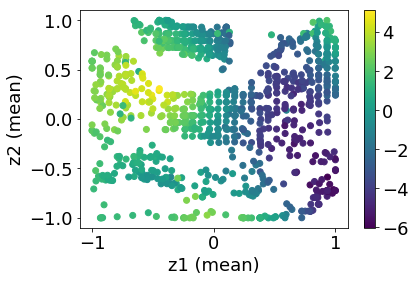

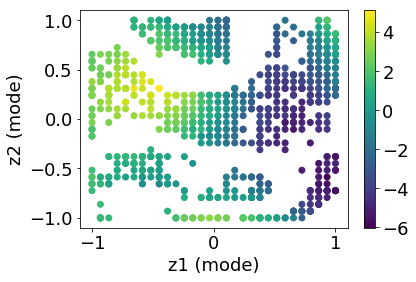

estimated x-mode: [10.87595846  1.55691188  7.43932107]
estimated x-mode on map: [-0.51724138  0.31034483]


In [1]:
# -*- coding: utf-8 -*- 
# %reset -f
"""
@author: Hiromasa Kaneko
"""
%matplotlib inline
# Demonstration of inverse GTMR (Generative Topographic Mapping Regression)

import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.datasets.samples_generator import make_swiss_roll
import matplotlib.figure as figure
import mpl_toolkits.mplot3d

from gtm import gtm

target_y_value = 4  # y-target for inverse analysis

# settings
shape_of_map = [30, 30]
shape_of_rbf_centers = [4, 4]
variance_of_rbfs = 0.5
lambda_in_em_algorithm = 0.001
number_of_iterations = 300
display_flag = 1
number_of_samples = 1000
noise_ratio_of_y = 0.1
random_state_number = 30000

# load a swiss roll dataset and make a y-variable
original_X, color = make_swiss_roll(number_of_samples, 0, random_state=10)
X = original_X
raw_y = 0.3 * original_X[:, 0] - 0.1 * original_X[:, 1] + 0.2 * original_X[:, 2]
original_y = raw_y + noise_ratio_of_y * raw_y.std(ddof=1) * np.random.randn(len(raw_y))
# plot
plt.rcParams["font.size"] = 18
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(original_X[:, 0], original_X[:, 1], original_X[:, 2], c=original_y)
fig.colorbar(p)
plt.show()

# autoscaling
autoscaled_X = (original_X - original_X.mean(axis=0)) / original_X.std(axis=0, ddof=1)
autoscaled_y = (original_y - original_y.mean()) / original_y.std(ddof=1)

# construct GTMR model
input_dataset = np.c_[autoscaled_X, autoscaled_y]
model = gtm(shape_of_map, shape_of_rbf_centers, variance_of_rbfs, lambda_in_em_algorithm, number_of_iterations,
            display_flag)
model.fit(input_dataset)
if model.success_flag:
    # calculate of responsibilities
    responsibilities = model.responsibility(input_dataset)

    # plot the mean of responsibilities
    means = responsibilities.dot(model.map_grids)
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(means[:, 0], means[:, 1], c=original_y)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mean)")
    plt.ylabel("z2 (mean)")
    plt.show()

    # plot the mode of responsibilities
    modes = model.map_grids[responsibilities.argmax(axis=1), :]
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(modes[:, 0], modes[:, 1], c=original_y)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mode)")
    plt.ylabel("z2 (mode)")
    plt.show()

# inverse analysis
estimated_x_mean, estimated_x_mode, responsibilities_inverse, py = model.inverse_gtmr(target_y_value)
estimated_x_mean = estimated_x_mean * original_X.std(axis=0, ddof=1) + original_X.mean(axis=0)
estimated_x_mode = estimated_x_mode * original_X.std(axis=0, ddof=1) + original_X.mean(axis=0)
# print("estimated x-mean: {0}".format(estimated_x_mean))
print("estimated x-mode: {0}".format(estimated_x_mode))

estimated_x_mean_on_map = responsibilities_inverse.dot(model.map_grids)
estimated_x_mode_on_map = model.map_grids[np.argmax(responsibilities_inverse), :]
# print("estimated x-mean on map: {0}".format(estimated_x_mean_on_map))
print("estimated x-mode on map: {0}".format(estimated_x_mode_on_map))
